Finding chessboard

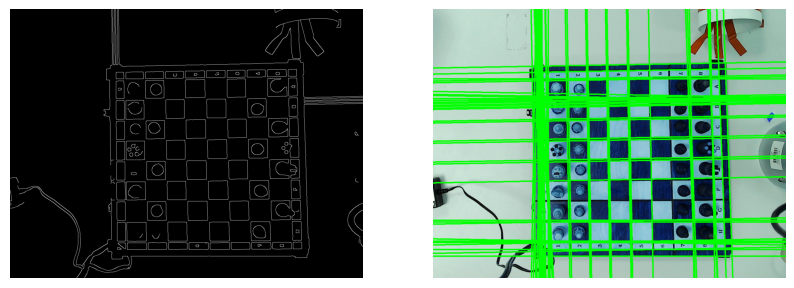

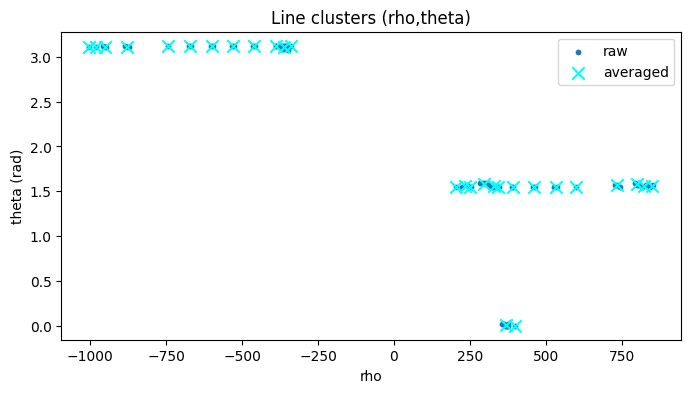

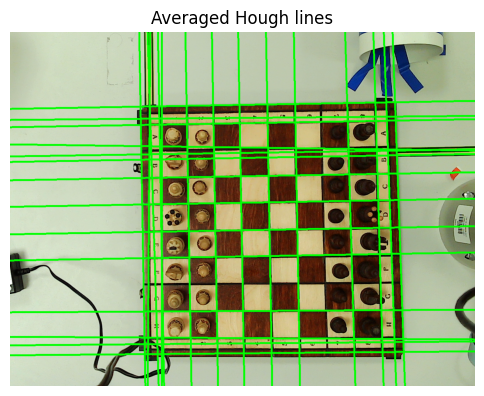

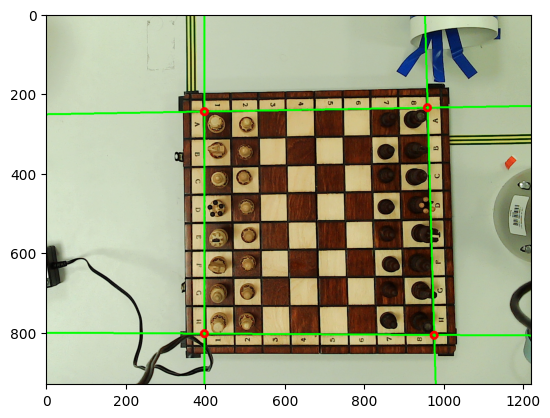

[[np.float64(976.5520300364257), np.float64(807.0282543045247)], [np.float64(398.0), np.float64(803.6623688076756)], [np.float64(959.9159129619725), np.float64(235.28301440598707)], [np.float64(398.0), np.float64(245.09128002199108)]]
[[977. 807.]
 [398. 804.]
 [960. 235.]
 [398. 245.]]


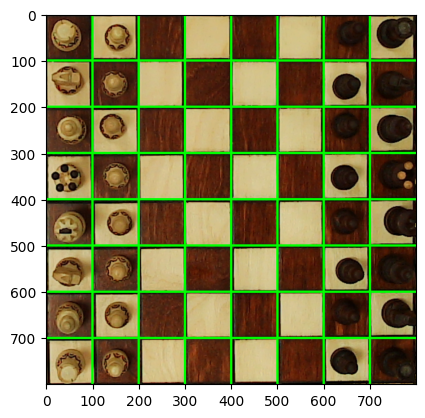

In [84]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from typing import List
import itertools
import math


def cannyHough(img, show_output=False):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    blur = cv2.bilateralFilter(blur, 13, 100, 100)

    edges = cv2.Canny(blur, 75 ,150)

    lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=120)

    lines_list = []
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            lines_list.append((float(rho), float(theta)))

    if not show_output:
        return lines_list
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))

    img_copy = img.copy()
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 2000 * (-b))
            y1 = int(y0 + 2000 * (a))
            x2 = int(x0 - 2000 * (-b))
            y2 = int(y0 - 2000 * (a))
            cv2.line(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 3)
    ax[0].imshow(edges, 'gray')
    ax[0].axis('off')
    ax[1].imshow(img_copy)
    ax[1].axis('off')
    plt.show()

    return lines_list

def averageLines(lines, img, show_output=False):
    rho_tol = 20.0          # pixels
    theta_tol = np.deg2rad(30.0)  # radians

    if lines is None:
        return
    
    clusters = []
    for line in lines:
        rho, theta = line
        placed = False
        for cl in clusters:
            r_avg, t_avg, cnt = cl
            dtheta = abs(theta - t_avg)
            dtheta = min(dtheta, 2*np.pi - dtheta)
            if abs(rho - r_avg) < rho_tol and dtheta < theta_tol:
                new_cnt = cnt + 1
                cl[0] = (r_avg*cnt + rho) / new_cnt

                x = np.cos(t_avg)*cnt + np.cos(theta)
                y = np.sin(t_avg)*cnt + np.sin(theta)
                cl[1] = np.arctan2(y, x)
                cl[2] = new_cnt
                placed = True
                break

        if not placed:
            clusters.append([rho, theta, 1])

    avg_lines = [(cl[0], cl[1]) for cl in clusters]

    if not show_output:
        return avg_lines

    # Draw averaged lines on a copy
    vis_avg = img.copy()
    for rho, theta in avg_lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 2000 * (-b))
        y1 = int(y0 + 2000 * (a))
        x2 = int(x0 - 2000 * (-b))
        y2 = int(y0 - 2000 * (a))
        cv2.line(vis_avg, (x1, y1), (x2, y2), (0, 255, 0), 3)

    # Show original detected rho/theta and averaged ones
    

    plt.figure(figsize=(8,4))
    if len(lines)>0:
        rs, ts = zip(*lines)
        plt.scatter(rs, ts, s=10, label='raw')
    if len(avg_lines)>0:
        ars, ats = zip(*avg_lines)
        plt.scatter(ars, ats, c='cyan', s=80, marker='x', label='averaged')
    plt.xlabel('rho'); plt.ylabel('theta (rad)'); plt.legend(); plt.title('Line clusters (rho,theta)')
    plt.show()

    plt.figure(figsize=(6,6)); plt.imshow(cv2.cvtColor(vis_avg, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title('Averaged Hough lines'); plt.show()

    return avg_lines

def show_lines(img, lines):
    vis = img.copy()
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 2000 * (-b))
        y1 = int(y0 + 2000 * (a))
        x2 = int(x0 - 2000 * (-b))
        y2 = int(y0 - 2000 * (a))
        cv2.line(vis, (x1, y1), (x2, y2), (0, 255, 0), 3)
    plt.imshow(vis)
    plt.show()

def angle_diff(a, b):
    """Return minimal absolute difference between two angles in radians."""
    d = np.abs(a - b) % np.pi
    return min(d, np.pi - d)

def intersections_from_rho_theta(rhos, thetas, deg=False, eps=1e-9):
    """
    rhos: iterable of length N (here N=4)
    thetas: iterable of length N (same units)
    deg: if True, input thetas are in degrees (converted to radians)
    eps: threshold to consider two lines parallel (|denom| < eps)
    Returns: list of dicts: [{'pair': (i,j), 'x': x, 'y': y, 'parallel': bool}, ...]
    """
    box_max = 2000
    box_min = 0
    rhos = np.asarray(rhos, dtype=float)
    thetas = np.asarray(thetas, dtype=float)
    if deg:
        thetas = np.deg2rad(thetas)

    results = []
    N = len(rhos)
    for i,j in itertools.combinations(range(N), 2):
        rho1, th1 = rhos[i], thetas[i]
        rho2, th2 = rhos[j], thetas[j]
        denom = math.sin(th2 - th1)  # sin(theta2-theta1)
        x = (rho1 * math.sin(th2) - rho2 * math.sin(th1)) / denom
        y = (-rho1 * math.cos(th2) + rho2 * math.cos(th1)) / denom
        if box_min <= x <= box_max and box_min <= y <= box_max:
            results.append([x , y])
    return results

def x_intercept(line):
    rho, theta = line
    if np.cos(theta) != 0:
        return rho / np.cos(theta)  # x where y=0
    else:
        return float('inf')  # vertical line
    
def y_intercept(line):
    rho, theta = line
    if np.sin(theta) != 0:
        return rho / np.sin(theta)  # x where y=0
    else:
        return float('inf')  # vertical line

def order_points(pts):
    # pts: array of 4 points [[x1,y1],[x2,y2],...]
    rect = np.zeros((4, 2), dtype="float32")
    
    # sum of coordinates: top-left has smallest sum, bottom-right has largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[3] = pts[np.argmax(s)]  # bottom-right
    
    # difference of coordinates: top-right has smallest diff, bottom-left has largest diff
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[2] = pts[np.argmax(diff)]  # bottom-left
    
    return rect

def findChessboard(lines, img, show_optput=False):

    h_lines = []
    v_lines = []

    theta_tol = np.deg2rad(10.0)
    h_val = np.pi/2
    v_val = 0.0
    for line in lines:
        rho, theta = line
        h_diff = angle_diff(theta, h_val)
        v_diff = angle_diff(theta, v_val)
        if h_diff < v_diff:
            h_lines.append([rho, theta])
        elif v_diff < h_diff:
            v_lines.append([rho, theta])
    

    h_lines.sort(key=y_intercept)
    v_lines.sort(key=x_intercept)

    y_inter = [y_intercept(e) for e in h_lines]
    h_diffs = []
    for i in range(len(y_inter)-1):
        h_diffs.append(y_inter[i+1] - y_inter[i])
    h_median = np.median(h_diffs)
    
    for i in range(len(h_diffs)):
        if h_diffs[i] > h_median - 10:
            h_min = h_lines[i]
            break

    for i in range(len(h_diffs)):
        idx = len(h_diffs)-1-i
        if h_diffs[idx] > h_median - 10:
            h_max = h_lines[idx+1]
            break

    x_inter = [x_intercept(e) for e in v_lines]
    v_diffs = []
    for i in range(len(x_inter)-1):
        v_diffs.append(x_inter[i+1] - x_inter[i])
    v_median = np.median(v_diffs)

    tol = 3
    for i in range(len(v_diffs)):
        if v_diffs[i] > v_median - tol:
            v_min = v_lines[i]
            break

    for i in range(len(v_diffs)):
        idx = len(v_diffs)-1-i
        if v_diffs[idx] > v_median - tol:
            v_max = v_lines[idx+1]
            break


    bounding_lines = [h_max, h_min, v_max, v_min]
    rhos = [e[0] for e in bounding_lines]
    thetas = [e[1] for e in bounding_lines]

    corners = intersections_from_rho_theta(rhos, thetas)
    if not show_optput:
        return corners


     # Draw averaged lines on a copy
    if show_optput:
        vis_corners = img.copy()
        for rho, theta in bounding_lines:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 2000 * (-b))
            y1 = int(y0 + 2000 * (a))
            x2 = int(x0 - 2000 * (-b))
            y2 = int(y0 - 2000 * (a))
            cv2.line(vis_corners, (x1, y1), (x2, y2), (0, 255, 0), 3)

        for x,y in corners:
            cv2.circle(vis_corners, (int(x), int(y)), 8, (0, 0, 255), 6)

        plt.imshow(cv2.cvtColor(vis_corners, cv2.COLOR_BGR2RGB))
        plt.show()
    return corners
    
def transform_image(img, corners, show_output=False):
    width, height = 800, 800
    corners = np.float32(corners)
    corners = order_points(corners)
    pts2 = np.float32([[0,0], [width, 0], [0, height], [width, height]])
    matrix = cv2.getPerspectiveTransform(corners, pts2)
    result = cv2.warpPerspective(img, matrix, (800, 800))
    if show_output:
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.show()
    return matrix, result

def divide_chessboard(img, show_output=False):
    # Number of cells
    rows, cols = 8, 8
    cell_width = img.shape[1] // cols
    cell_height = img.shape[0] // rows

    # Draw vertical lines
    img_vis = img.copy()
    for i in range(1, cols):
        x = i * cell_width
        cv2.line(img_vis, (x, 0), (x, 800), (0,255, 0), 4)

    # Draw horizontal lines
    for i in range(1, rows):
        y = i * cell_height
        cv2.line(img_vis, (0, y), (800, y), (0,255, 0), 4)
    if show_output:
        plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
        plt.show()
    return cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)


img_color = cv2.imread("img/game/moveq0.png", cv2.IMREAD_COLOR)
# img_color = cv2.resize(img_color, (800, 800))
lines = cannyHough(img_color, True)

avg_lines = averageLines(lines, img_color, True)
corners = findChessboard(avg_lines, img_color, True)
print(corners)
# corners[0][1] -= 13
# corners[0][0] -= 15

# corners[1][1] -= 13
# corners[1][0] += 15

# corners[2][1] += 15
# corners[2][0] -= 15

# corners[3][1] += 15
# corners[3][0] += 15

print(np.round(corners))
corners = np.round(corners)
trsf_matrix, img_trsf = transform_image(img_color, corners, False)
div = divide_chessboard(img_trsf, True)

Finding pieces

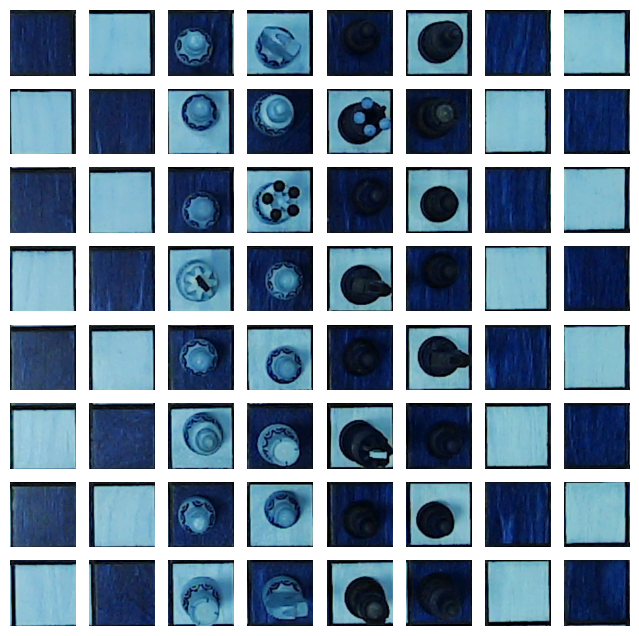

In [116]:
import chess
import cv2


class MoveDetector2:
    def __init__(
        self, start_position="rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
    ):
        self.img_size = (800, 800)
        self.img_height = 800
        self.num_cells = 8
        self.square_height = 100
        self.last_frame = cv2.imread("img/game/moveq0.png", cv2.IMREAD_COLOR)
        self.trsf_matrix = None

        self.board = chess.Board(start_position)
        corners = [[977.0, 807.0], [398.0, 804.0], [960.0, 235.0], [398.0, 245.0]]
        self.find_transform_from_corners(self.last_frame, corners)
        self.empty = self.preproces_img(self.last_frame)

    def find_transform_from_corners(self, img, corners):
        self.trsf_matrix, img_trsf = transform_image(img, corners, False)

    def preproces_img(self, img):
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = img[:,:,2]
        img = cv2.warpPerspective(img, self.trsf_matrix, self.img_size)
        return img

    def convert_xy_to_chess_sqr(self, x, y):
        col = int(x)
        row = int(y)
        col_letter = chr(ord("a") + col)
        row_number = str(row + 1)
        return f"{col_letter}{row_number}"

    def detect_pieces(self, frame):
        frame = self.preproces_img(frame)
        # frame = cv2.absdiff(frame, self.empty)
        fig, ax = plt.subplots(8, 8, figsize=(8, 8))
        iter = 2
        for row in range(self.num_cells):
            for col in range(self.num_cells):
                square = frame[
                    row * self.square_height : (row + 1) * self.square_height,
                    col * self.square_height : (col + 1) * self.square_height,
                ]
                cv2.imwrite(
                    f"/home/igorsiata/ur3_chess_player/vision_system/img/dataset/img_{(64*iter) + (row+col*8)}.png",
                    square,
                )
                ax[row, col].axis("off")
                ax[row, col].imshow(square, cmap="gray")
        plt.show

    def is_piece_on_sqr(self, sqr):
        pass


md2 = MoveDetector2()
img_color = cv2.imread("img/game/moveq0.png", cv2.IMREAD_COLOR)
md2.detect_pieces(img_color)

CNN

In [156]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import time

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1️⃣ Transform for color images
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# 2️⃣ Load dataset from folders
dataset = datasets.ImageFolder(root="/home/igorsiata/ur3_chess_player/vision_system/img/dataset", transform=transform)

# 3️⃣ Split into train/test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 4️⃣ Simple CNN
class ChessCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),  # input: 3 channels
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 3),  # 96/8 = 12 after 3 pooling layers
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = ChessCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 5️⃣ Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# 6️⃣ Evaluation on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct/total*100:.2f}%")

torch.save(model.state_dict(), "model_weights.pth")




Epoch 1/20, Loss: 1.0896
Epoch 2/20, Loss: 0.9783
Epoch 3/20, Loss: 0.8189
Epoch 4/20, Loss: 0.6395
Epoch 5/20, Loss: 0.4300
Epoch 6/20, Loss: 0.2476
Epoch 7/20, Loss: 0.1333
Epoch 8/20, Loss: 0.0698
Epoch 9/20, Loss: 0.0549
Epoch 10/20, Loss: 0.0475
Epoch 11/20, Loss: 0.0401
Epoch 12/20, Loss: 0.0418
Epoch 13/20, Loss: 0.0316
Epoch 14/20, Loss: 0.0332
Epoch 15/20, Loss: 0.0289
Epoch 16/20, Loss: 0.0199
Epoch 17/20, Loss: 0.0273
Epoch 18/20, Loss: 0.0241
Epoch 19/20, Loss: 0.0179
Epoch 20/20, Loss: 0.0179
Test Accuracy: 100.00%


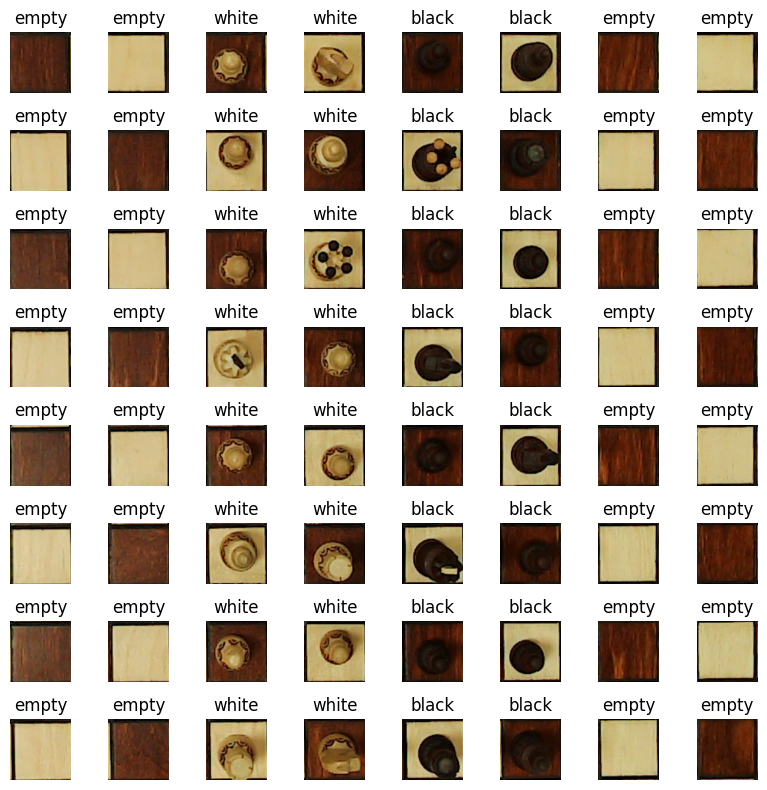

Inference time: 753.85 ms
 e  e  e  w  e  e  e  e 
 e  e  e  e  e  e  e  e 
 e  e  e  w  w  w  w  w 
 e  e  e  w  e  w  w  w 
 e  e  e  e  e  w  w  w 
 e  e  e  e  e  w  w  b 
 e  e  e  e  e  w  w  w 
 e  e  e  e  e  w  w  w 


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import chess
import cv2

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
labels = ["b", "e", "w"]

def classify_square(model, img):
    labels = ["black", "empty", "white"]
    img = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out = model(img)
        cls = out.argmax(1).item()
    return labels[cls]



class MoveDetector2:
    def __init__(
        self, start_position="rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
    ):
        self.img_size = (800, 800)
        self.img_height = 800
        self.num_cells = 8
        self.square_height = 100
        self.last_frame = cv2.imread("img/game/moveq0.png", cv2.IMREAD_COLOR)
        self.trsf_matrix = None

        self.board = chess.Board(start_position)
        corners = [[977.0, 807.0], [398.0, 804.0], [960.0, 235.0], [398.0, 245.0]]
        self.find_transform_from_corners(self.last_frame, corners)
        self.empty = self.preproces_img(self.last_frame)

    def find_transform_from_corners(self, img, corners):
        self.trsf_matrix, img_trsf = transform_image(img, corners, False)

    def preproces_img(self, img):
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = img[:,:,2]
        img = cv2.warpPerspective(img, self.trsf_matrix, self.img_size)
        return img

    def convert_xy_to_chess_sqr(self, x, y):
        col = int(x)
        row = int(y)
        col_letter = chr(ord("a") + col)
        row_number = str(row + 1)
        return f"{col_letter}{row_number}"

    def detect_pieces(self, frame):
        start = time.time()
        frame = self.preproces_img(frame)
        # frame = cv2.absdiff(frame, self.empty)
        fig, ax = plt.subplots(8, 8, figsize=(8, 8))
        for row in range(self.num_cells):
            for col in range(self.num_cells):
                square = frame[
                    row * self.square_height : (row + 1) * self.square_height,
                    col * self.square_height : (col + 1) * self.square_height,
                ]
                ax[row, col].axis("off")
                square_pil = Image.fromarray(cv2.cvtColor(square, cv2.COLOR_BGR2RGB))
                label = classify_square(model, square_pil)
                ax[row, col].set_title(label)
                ax[row, col].imshow(cv2.cvtColor(square, cv2.COLOR_BGR2RGB))
        end = time.time()
        plt.tight_layout()
        plt.show()
        
        print(f"Inference time: {(end-start)*1000:.2f} ms")

    def detect_pieces2(self,frame):
        squares = []
        for row in range(self.num_cells):
            for col in range(self.num_cells):
                sq = frame[
                    row*self.square_height:(row+1)*self.square_height,
                    col*self.square_height:(col+1)*self.square_height
                ]
                sq_pil = Image.fromarray(cv2.cvtColor(sq, cv2.COLOR_BGR2RGB))
                squares.append(transform(sq_pil))
        
        # Batch inference
        batch = torch.stack(squares).to(DEVICE)
        with torch.no_grad():
            outputs = model(batch)
            preds = outputs.argmax(dim=1).cpu().tolist()

        # Convert to labels
        board_labels = [labels[p] for p in preds]
        for idx, l in enumerate(board_labels):
            if idx%8== 7:
                print(f" {l} ")
            else:
                print(f" {l} ", end="")
        board_str = ",".join(board_labels)
        # print(board_str)

    def is_piece_on_sqr(self, sqr):
        pass


md2 = MoveDetector2()
img_color = cv2.imread("img/game/moveq0.png", cv2.IMREAD_COLOR)
md2.detect_pieces(img_color)
md2.detect_pieces2(img_color)


In [142]:
import chess
import PIL

board = chess.Board("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1")
is_white = False
if is_white:
    chess_color = chess.WHITE
    piece_label = 1
else:
    chess_color = chess.BLACK
    piece_label = 2

squares = list(board.pieces(chess.PAWN, chess_color)) + \
                list(board.pieces(chess.KNIGHT, chess_color)) + \
                list(board.pieces(chess.BISHOP, chess_color)) + \
                list(board.pieces(chess.ROOK, chess_color)) + \
                list(board.pieces(chess.QUEEN, chess_color)) + \
                list(board.pieces(chess.KING, chess_color))
squares.sort()
print(squares)


squares = []
last_frame = cv2.imread("img/game/moveq0.png", cv2.IMREAD_COLOR)
for row in range(8):
    for col in range(8):
        sq = last_frame[
            row*100:(row+1)*100,
            col*100:(col+1)*100
        ]
        sq_pil = Image.fromarray(cv2.cvtColor(sq, cv2.COLOR_BGR2RGB))
        squares.append(transform(sq_pil))

# Batch inference
batch = torch.stack(squares).to(DEVICE)
with torch.no_grad():
    outputs = model(batch)
    preds = outputs.argmax(dim=1).cpu().tolist()

# Convert to labels
board_labels = [labels[p] for p in preds]
print(preds)
board_str = ",".join(board_labels)
print(f"Published board: {board_str}")

[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2]


TypeError: sequence item 0: expected str instance, Tensor found

In [22]:
def apply_transform(img, matrix, show_output=False):
    result = cv2.warpPerspective(img, matrix, (800, 800))
    if show_output:
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.show()
    return result

def find_moved_cells(img1, img2):
    gray1 = cv2.cvtColor(img1_t, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2_t, cv2.COLOR_BGR2GRAY)

    # Make sure the images have the same size
    if img1.shape != img2.shape:
        raise ValueError("Images must have the same dimensions")

    diff = cv2.absdiff(gray1, gray2)

    # Optional: apply a threshold to highlight the differences
    _, diff_thresh = cv2.threshold(diff, 20, 255, cv2.THRESH_BINARY)
    diff_thres = cv2.erode(diff_thresh, (3,3))

    rows, cols = 8, 8
    cell_width = diff_thresh.shape[1] // cols
    cell_height = diff_thresh.shape[0] // rows

    img_vis = diff_thresh.copy()
    for i in range(1, cols):
        x = i * cell_width
        cv2.line(img_vis, (x, 0), (x, 800), (255,255, 255), 2)

    # Draw horizontal lines
    for i in range(1, rows):
        y = i * cell_height
        cv2.line(img_vis, (0, y), (800, y), (255,255, 255), 2)
    plt.imshow(img_vis, 'gray')
    plt.show()
    sum_thres = 500
    for row in range(8):
        for col in range(8):
            acc = np.sum(diff_thresh[row*100:(row+1)*100, col*100:(col+1)*100])
            acc = acc//255
            if acc >= sum_thres:
                print(row, col, acc)


img1 = cv2.imread('img/game3/move10.png')
img2 = cv2.imread('img/game3/move30.png')

img1_t = apply_transform(img1, trsf_matrix)
img2_t = apply_transform(img2, trsf_matrix)

divide_chessboard(img1_t, True)
divide_chessboard(img2_t, True)

find_moved_cells(img1_t, img2_t)


[ WARN:0@436.732] global loadsave.cpp:275 findDecoder imread_('img/game3/move10.png'): can't open/read file: check file path/integrity
[ WARN:0@436.732] global loadsave.cpp:275 findDecoder imread_('img/game3/move30.png'): can't open/read file: check file path/integrity


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/imgwarp.cpp:3285: error: (-215:Assertion failed) _src.total() > 0 in function 'warpPerspective'


In [ ]:
import os
from glob import glob
from pathlib import Path

class MoveDetector:
    def __init__(self):
        self.img_size = (800 , 800)
        self.img_height = 800
        self.num_cells = 8
        self.last_stable_frame = None
        self.last_frame = None
        self.trsf_matrix = None


    def find_transform(self, img):
        lines = cannyHough(img, False)
        avg_lines = averageLines(lines, img_color, False)
        avg_lines = averageLines(avg_lines, img_color, False)
        corners = findChessboard(avg_lines, img_color, False)
        self.trsf_matrix, img_trsf = transform_image(img_color, corners, False)


    def preproces_img(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.warpPerspective(img, self.trsf_matrix, self.img_size) 
        return img

    def detect_move(self, new_frame):
        move_discard_thresh = 6000
        move_made_thresh = 4000

        new_frame = self.preproces_img(new_frame)
        if self.last_frame is None:
            self.last_frame = new_frame
            return None

        diff = cv2.absdiff(self.last_frame, new_frame)
        _, diff_thresh = cv2.threshold(diff, 20, 255, cv2.THRESH_BINARY)
        diff_thresh = cv2.erode(diff_thresh, (3,3))
        move_count = np.sum(diff_thresh)//255

        

        if move_count >= move_discard_thresh:
            self.last_frame = new_frame
            return None
        
        if self.last_stable_frame is None:
            self.last_frame = new_frame
            self.last_stable_frame = new_frame
            return None
        
        diff = cv2.absdiff(self.last_stable_frame, new_frame)
        _, diff_thresh = cv2.threshold(diff, 20, 1, cv2.THRESH_BINARY)
        diff_thresh = cv2.erode(diff_thresh, (3,3))

        move_count = np.sum(diff_thresh)
        if move_count <= move_made_thresh:
            self.last_frame = new_frame
            self.last_stable_frame = new_frame
            return None
        
        sum_thres = 2000
        block_size = 100

        # reshape into blocks of 100x100
        blocks = diff_thresh.reshape(8, block_size, 8, block_size)
        # sum over each block
        block_sums = blocks.sum(axis=(1, 3))

        # find indices where sum >= threshold
        rows, cols = np.where(block_sums >= sum_thres)

        # store row, col, and sum (count) in a list
        sqr_changed = [(r, c, block_sums[r, c]) for r, c in zip(rows, cols)]

        # print results
        for r, c, count in sqr_changed:
            print(r, c, count)
        
        if len(sqr_changed) > 2:
            self.last_frame = new_frame
            return None
        self.last_frame = new_frame
        self.last_stable_frame = new_frame

        rows, cols = 8, 8
        cell_width = diff_thresh.shape[1] // cols
        cell_height = diff_thresh.shape[0] // rows
        img_vis = diff_thresh.copy()
        for i in range(1, cols):
            x = i * cell_width
            cv2.line(img_vis, (x, 0), (x, 800), (255,255, 255), 2)

        # Draw horizontal lines
        for i in range(1, rows):
            y = i * cell_height
            cv2.line(img_vis, (0, y), (800, y), (255,255, 255), 2)
        plt.imshow(img_vis, 'gray', vmin=0, vmax=1)
        plt.show()

        

move_detector = MoveDetector()
move_detector.find_transform(cv2.imread('img/game/empty.png'))


directory = Path("/home/igorsiata/ur3_chess_player/vision_system/img/game")

for filename in sorted(directory.glob("move*.png"), key=lambda f: int(f.stem[4:])):
    filepath = os.path.join(directory, filename)
    if os.path.isfile(filepath):
        img = cv2.imread(filepath)
        move_detector.detect_move(img)

NameError: name 'cv2' is not defined

In [ ]:
def apply_transform(img, matrix, show_output=False):
    img = cv2.resize(img, (800, 800))
    result = cv2.warpPerspective(img, matrix, (800, 800))
    if show_output:
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.show()
    return result

def find_moved_cells(img1, img2):
    gray1 = cv2.cvtColor(img1_t, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2_t, cv2.COLOR_BGR2GRAY)

    # Make sure the images have the same size
    if img1.shape != img2.shape:
        raise ValueError("Images must have the same dimensions")

    diff = cv2.absdiff(gray1, gray2)

    # Optional: apply a threshold to highlight the differences
    _, diff_thresh = cv2.threshold(diff, 20, 255, cv2.THRESH_BINARY)
    diff_thres = cv2.erode(diff_thresh, (3,3))

    rows, cols = 8, 8
    cell_width = diff_thresh.shape[1] // cols
    cell_height = diff_thresh.shape[0] // rows

    img_vis = diff_thresh.copy()
    for i in range(1, cols):
        x = i * cell_width
        cv2.line(img_vis, (x, 0), (x, 800), (255,255, 255), 2)

    # Draw horizontal lines
    for i in range(1, rows):
        y = i * cell_height
        cv2.line(img_vis, (0, y), (800, y), (255,255, 255), 2)
    plt.imshow(img_vis, 'gray')
    plt.show()
    sum_thres = 500
    for row in range(8):
        for col in range(8):
            acc = np.sum(diff_thresh[row*100:(row+1)*100, col*100:(col+1)*100])
            acc = acc//255
            if acc >= sum_thres:
                print(row, col, acc)


/home/igorsiata/ur3_chess_player/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/igorsiata/ur3_chess_player/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


UnboundLocalError: local variable 'v_max' referenced before assignment

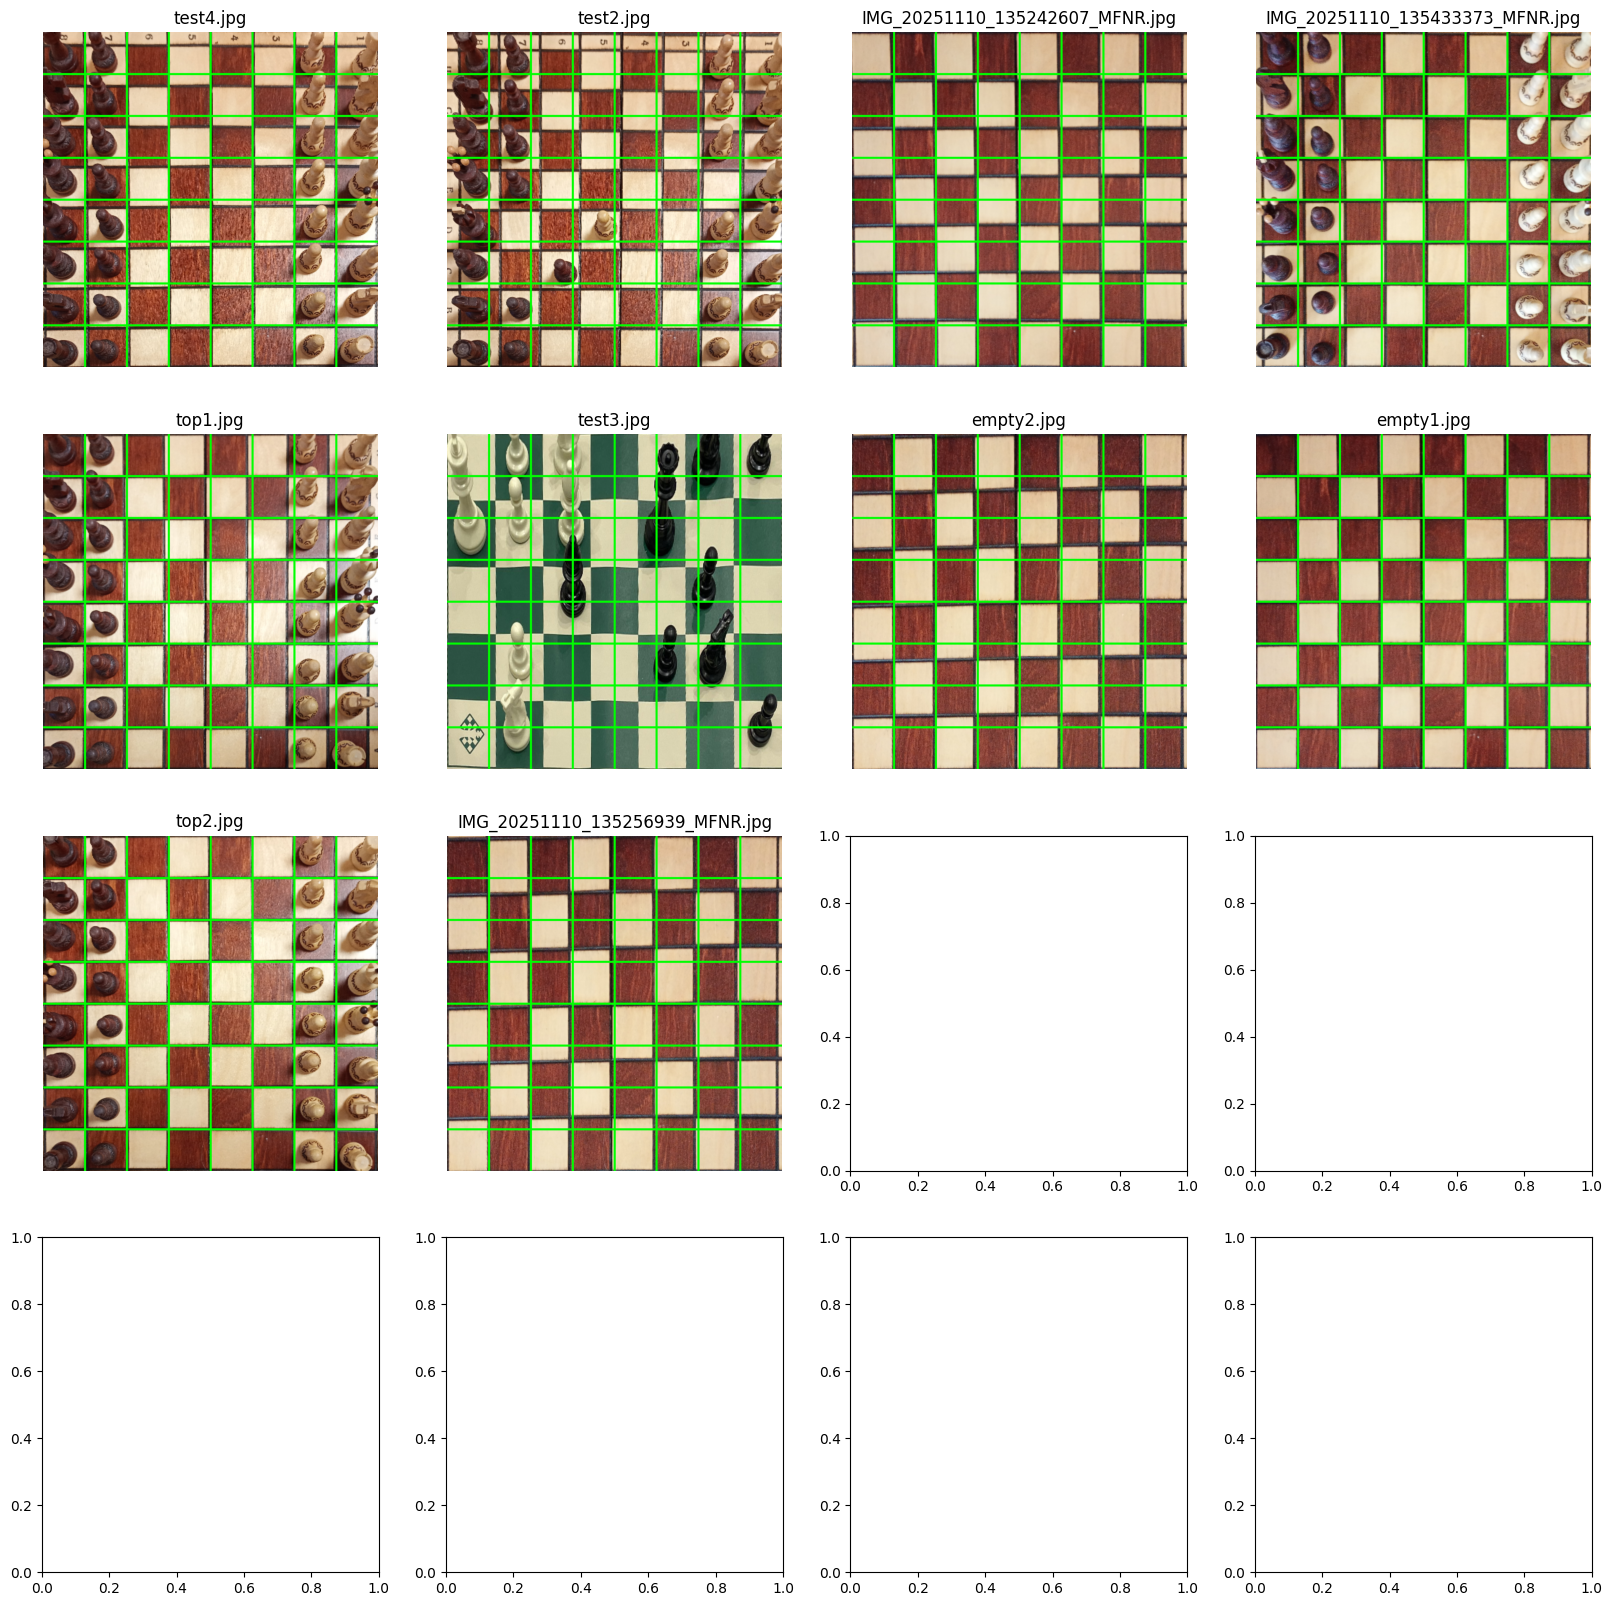

In [ ]:
def fitChessboard(img_path):
    img_color = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_color = cv2.resize(img_color, (800, 800))
    lines = cannyHough(img_color, False)
    avg_lines = averageLines(lines, img_color, False)
    # avg_lines = averageLines(avg_lines, img_color, False)
    corners = findChessboard(avg_lines, img_color, False)
    img_trsf = transform_image(img_color, corners, False)
    div = divide_chessboard(img_trsf, False)
    return div

import os

directory = "/home/igorsiata/ur3_chess_player/vision_system/img"

fig, ax = plt.subplots(4,4, figsize=(20,20))

for idx, filename in enumerate(os.listdir(directory)):
    if idx > 15:
        break
    file_path = os.path.join(directory, filename)
    if os.path.isfile(file_path):
        res = fitChessboard(file_path)
        ax[idx//4, idx%4].imshow(res)
        ax[idx//4, idx%4].set_title(os.path.basename(filename))
        ax[idx//4, idx%4].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import chess

def always_promote_to_queen(move: chess.Move):
        if move.promotion != None:
            return chess.Move(move.from_square, move.to_square, promotion=chess.QUEEN)
        return move

move = chess.Move.from_uci("g7h8k")
move = always_promote_to_queen(move)
print(move.uci())

g7h8q
